In [103]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import os

# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='~/PYTORCH/data/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [104]:
#vgg19(pretrained=True)
from torchvision.models import VGG19_Weights

In [105]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.vgg = vgg19(VGG19_Weights.IMAGENET1K_V1)
        self.feature_conv = self.vgg.features[:36]
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.classifier = self.vgg.classifier
        self.gradients = None

    def activations_hook(self, grad): # # hook for the gradients of the activations
        self.gradients = grad

    def forward(self, x):
        x = self.feature_conv(x)
        h = x.register_hook(self.activations_hook)# register the hook

        x = self.max_pool(x)# apply the remaining pooling
        x = x.view((1,-1))
        x = self.classifier(x)

        return x

    def get_activations_gradient(self):# method for the gradient extraction
        return self.gradients

    def get_activations(self,x):# method for the activation extraction
        return self.feature_conv(x)



## Drawing CAM

In [106]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img,_ = next(iter(dataloader))

# get the most likely prediction of the model
pred = vgg(img)
pred.size()

/Users/ceyhun/opt/anaconda3/envs/Dataspell_1_env/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


torch.Size([1, 1000])

In [107]:
# get the gradient of the output with respect to the parameters of the model
pred[:, 386].backward()

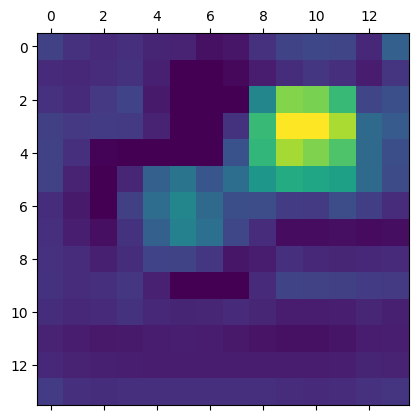

In [108]:


# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [109]:
import cv2
heatmap = heatmap.detach().numpy()
img = cv2.imread('data/Elephant/3.jpg')
print('Original Dimensions : ',img.shape)
width = int(img.shape[1])
height = int(img.shape[0])
dim = (width, height)

Original Dimensions :  (280, 419, 3)


In [110]:


heatmap = cv2.resize(heatmap,dim)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.6 + img
cv2.imwrite('data/map.jpg', superimposed_img)

True

In [237]:
# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='~/PYTORCH/data4/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [238]:
from torchvision.models import DenseNet201_Weights, DenseNet, densenet201, densenet169, AlexNet, alexnet
AlexNet()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [239]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        # get the pretrained DenseNet201 network
        self.densenet = alexnet()

        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features[:11]

        # add the average global pool
        self.global_avg_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)

        # get the classifier of the vgg19
        self.classifier = self.densenet.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # don't forget the pooling
        x = self.global_avg_pool(x)
        x = x.view((1,9216))
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features_conv(x)

In [240]:
# initialize the VGG model
dense = AlexNet()

# set the evaluation mode
dense.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader)) ####

# get the most likely prediction of the model
pred = dense(img)

In [241]:
pred

tensor([[-7.9003e-03, -1.9388e-03,  2.6323e-03, -8.7839e-03,  5.2789e-03,
         -1.3028e-03, -9.5726e-03,  3.3133e-03, -4.0845e-03,  1.2049e-02,
          1.6677e-02,  9.0482e-03,  5.9221e-03,  2.3724e-02,  7.6001e-03,
          2.5234e-02, -6.4588e-03, -2.0095e-02, -1.5409e-02,  4.7597e-03,
         -1.3288e-02,  4.2975e-04, -1.8384e-04,  1.5738e-02, -6.1577e-03,
         -1.6970e-02,  1.2597e-02, -8.6142e-03, -1.9285e-02, -4.6239e-03,
          7.7767e-03,  4.4933e-03, -3.8752e-03, -5.1486e-03, -1.5524e-03,
         -1.1868e-03,  2.4601e-03,  2.6638e-03, -2.8727e-03,  1.9961e-02,
         -6.5170e-03, -3.6957e-03, -7.4109e-03, -1.6679e-02, -1.0857e-02,
          2.0250e-02, -4.0980e-03, -3.4526e-03, -5.8905e-03, -6.4700e-03,
          1.2175e-02,  5.7413e-03,  5.3314e-05,  7.7525e-03, -4.2803e-03,
         -1.4624e-02, -1.6323e-03, -6.0247e-03,  6.1273e-03, -1.4134e-02,
         -1.3006e-02,  2.3608e-03, -1.4749e-02, -8.0603e-03, -6.1666e-03,
          1.2694e-02,  2.1119e-02,  1.

In [242]:
pred.argmax(dim=1)

tensor([134])

In [243]:
# get the gradient of the output with respect to the parameters of the model
pred[:, 772].backward()

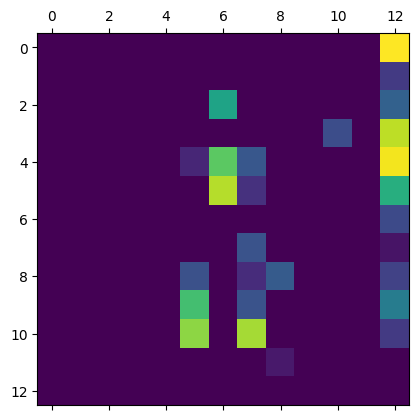

In [245]:
# pull the gradients out of the model
gradients = dense.get_activations_gradient()


# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = dense.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(256):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [246]:
import cv2
heatmap = heatmap.detach().numpy()
img = cv2.imread('data4/ben/kanser1.png')
print('Original Dimensions : ',img.shape)
width = int(img.shape[1])
height = int(img.shape[0])
dim = (width, height)

Original Dimensions :  (688, 561, 3)


In [247]:
heatmap = cv2.resize(heatmap,dim)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.6 + img
cv2.imwrite('data4/map.jpg', superimposed_img)

True